In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import trange

import pymc as pm

from pymc.variational.autoguide import (
    AutoDiagonalNormal,
    compile_svi_training_fn,
)

In [3]:
with pm.Model() as m:
    X = pm.Normal("X", 0, 1, size=(100, 3))
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 5, size=(3,))

    mu = alpha + X @ beta
    sigma = pm.HalfNormal("sigma", 1)
    y = pm.Normal("y", mu=mu, sigma=sigma)

    prior = pm.sample_prior_predictive(random_seed=38)

Sampling: [X, alpha, beta, sigma, y]


In [4]:
draw = 123
true_params = {}
true_params["alpha"] = prior.prior.alpha.sel(chain=0, draw=draw).values
true_params["beta"] = prior.prior.beta.sel(chain=0, draw=draw).values
true_params["sigma"] = prior.prior.sigma.sel(chain=0, draw=draw).values

X_data = prior.prior.X.sel(chain=0, draw=draw).values
y_data = prior.prior.y.sel(chain=0, draw=draw).values

In [5]:
true_params

{'alpha': array(11.82213038),
 'beta': array([-0.92518728,  0.27270752, -0.20081106]),
 'sigma': array(0.40007044)}

In [6]:
m_obs = pm.observe(pm.do(m, {X: X_data}), {"y": y_data})

In [7]:
with m_obs:
    idata = pm.sample(mp_ctx="spawn")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [8]:
guide = AutoDiagonalNormal(m_obs)

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "/home/ricardo/miniforge3/envs/pymc-dev/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ricardo/miniforge3/envs/pymc-dev/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/ricardo/miniforge3/envs/pymc-dev/lib/python3.12/importlib/__init__.py", line 130, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


In [9]:
guide.params_init_values

{sigma_loc: array(-0.81661984),
 sigma_scale: array(0.1),
 beta_loc: array([ 0.92426301, -0.29670779,  0.8050404 ]),
 beta_scale: array([0.1, 0.1, 0.1]),
 alpha_loc: array(-0.78312419),
 alpha_scale: array(0.1)}

In [10]:
true_loc_dict = {k.name: v for k, v in guide.params_init_values.items()}
for key, value in true_params.items():
    true_loc_dict[f"{key}_loc"] = value
true_loc_dict

{'sigma_loc': array(0.40007044),
 'sigma_scale': array(0.1),
 'beta_loc': array([-0.92518728,  0.27270752, -0.20081106]),
 'beta_scale': array([0.1, 0.1, 0.1]),
 'alpha_loc': array(11.82213038),
 'alpha_scale': array(0.1)}

In [11]:
f_loss_dloss = compile_svi_training_fn(m_obs, guide)

In [12]:
f_loss_dloss(np.array(500), **true_loc_dict)

[array(267.06378459),
 array(-145.85250709),
 array(154.00018737),
 array([-11.96743328,   2.79924744,  -2.35017322]),
 array([39.80956106, 53.99061549, 28.58763406]),
 array(0.96201239),
 array(43.20248001)]

In [13]:
init_param_values = {k.name: v for k, v in guide.params_init_values.items()}
opt_param_values = list(init_param_values.values())
learning_rate = 1e-5
n_iter = 2_000
loss_history = np.empty(n_iter)
progress_bar = trange(n_iter)
draws = np.array(500, dtype=int)
for i in progress_bar:
    loss, *grads = f_loss_dloss(draws, *opt_param_values)
    loss_history[i] = loss
    opt_param_values = [
        np.asarray(value - learning_rate * grad) for value, grad in zip(opt_param_values, grads)
    ]
    if i % 50 == 0:
        progress_bar.set_description(f"Loss: {loss:.2f}")
    if i % 5_000 == 0 and i > 0:
        learning_rate = max(learning_rate / 5, 1e-5)

optimized_params = dict(zip(init_param_values, opt_param_values))

Loss: 461.90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 626.57it/s]


{'sigma_loc': array(2.23715394),
 'sigma_scale': array(-1.810869),
 'beta_loc': array([ 0.75573259, -0.25781575,  0.7929361 ]),
 'beta_scale': array([0.09952254, 0.0982991 , 0.10187045]),
 'alpha_loc': array(-0.26682673),
 'alpha_scale': array(0.0957252)}

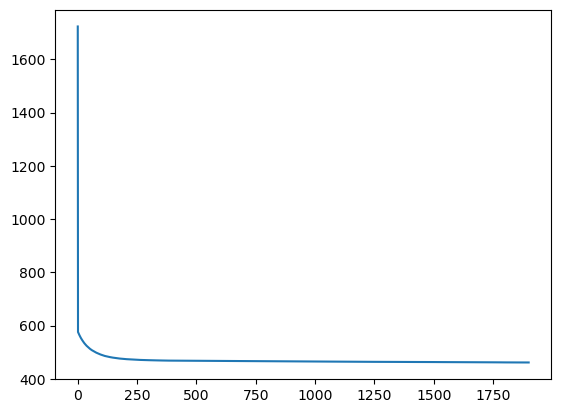

In [14]:
window_size = 100
kernel = np.full(window_size, 1 / window_size)
plt.plot(np.convolve(loss_history, kernel, mode="valid"))

In [15]:
n_iter = 2_000
loss_history = np.empty(n_iter)
progress_bar = trange(n_iter)
draws = np.array(500, dtype=int)
learning_rate = 1e-3
for i in progress_bar:
    loss, *grads = f_loss_dloss(draws, *opt_param_values)
    loss_history[i] = loss
    if any(np.isnan(d_loss).any() for d_loss in grads):
        print("Got nan, getting out")
        break
    opt_param_values = [
        np.asarray(value - learning_rate * grad) for value, grad in zip(opt_param_values, grads)
    ]

    if i % 50 == 0:
        progress_bar.set_description(f"Loss: {loss:.3f}")

optimized_params = dict(zip(init_param_values, opt_param_values))
optimized_params

Loss: 56.615: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 639.06it/s]


{'sigma_loc': array(-1.06275392),
 'sigma_scale': array(-2.61505505),
 'beta_loc': array([-0.91056208,  0.2716077 , -0.15967444]),
 'beta_scale': array([-3.28925422, -3.30663365, -3.19186797]),
 'alpha_loc': array(11.78263119),
 'alpha_scale': array(-3.30535793)}

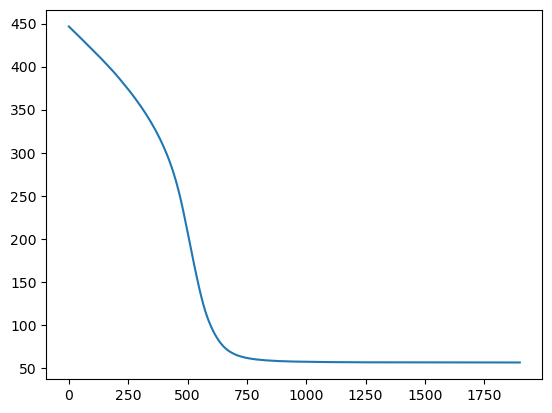

In [16]:
window_size = 100
kernel = np.full(window_size, 1 / window_size)
plt.plot(np.convolve(loss_history, kernel, mode="valid"))

In [17]:
true_params["beta"]

array([-0.92518728,  0.27270752, -0.20081106])

In [18]:
f_loss_dloss(np.array(500), **true_loc_dict)

[array(336.70736025),
 array(-268.97581555),
 array(395.78744606),
 array([-25.6507373 , -16.77466337, -20.70216968]),
 array([65.89290602, 59.15876422, 40.72710202]),
 array(-2.30179032),
 array(84.43618552)]

In [19]:
f_loss_dloss(np.array(500, dtype=int), *opt_param_values)

[array(56.60708962),
 array(0.12550054),
 array(0.0109625),
 array([-2.48193195, -0.68754083,  0.4438946 ]),
 array([0.08497766, 0.17830603, 0.1258238 ]),
 array(0.92784876),
 array(0.04297923)]

In [20]:
def inverse_softplus(x):
    return np.log(np.expm1(x))


mcmc_param_values = {}
mcmc_param_values["sigma_loc"] = np.log(idata.posterior["sigma"]).mean(("chain", "draw")).values
mcmc_param_values["sigma_scale"] = inverse_softplus(
    np.log(idata.posterior["sigma"]).std(("chain", "draw"))
).values

for param in ("beta", "alpha"):
    mcmc_param_values[f"{param}_loc"] = idata.posterior[param].mean(("chain", "draw")).values
    mcmc_param_values[f"{param}_scale"] = inverse_softplus(
        idata.posterior[param].std(("chain", "draw"))
    ).values

In [21]:
optimized_params

{'sigma_loc': array(-1.06275392),
 'sigma_scale': array(-2.61505505),
 'beta_loc': array([-0.91056208,  0.2716077 , -0.15967444]),
 'beta_scale': array([-3.28925422, -3.30663365, -3.19186797]),
 'alpha_loc': array(11.78263119),
 'alpha_scale': array(-3.30535793)}

In [22]:
mcmc_param_values

{'sigma_loc': array(-1.06716543),
 'sigma_scale': array(-2.58522658),
 'beta_loc': array([-0.90909634,  0.273244  , -0.15972646]),
 'beta_scale': array([-3.30488966, -3.31799041, -3.20806874]),
 'alpha_loc': array(11.78161401),
 'alpha_scale': array(-3.32904032)}

In [23]:
f_loss_dloss(np.array(500, dtype=int), **mcmc_param_values)

[array(56.61987761),
 array(-0.04343654),
 array(0.07714657),
 array([-2.03604289, -2.60214627,  0.07962086]),
 array([ 0.10942038,  0.11859711, -0.01547745]),
 array(-0.80121942),
 array(-0.00921298)]

## Todo:

- Does this "two models" frameworks fits into what we already have?
- rsample --> stochastic gradients? Or automatic reparameterization?
- figure out guide param initalization
- More flexible optimizers...